In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

In [2]:
from easydict import EasyDict
cfg = EasyDict()
cfg.SEQ_LENGTH = 250
cfg.TILE_SIZE = 16
cfg.OUT_SIZE = 1
cfg.TRAIN = EasyDict()
cfg.TRAIN.EPOCH = 0
cfg.TRAIN.EPOCH_SIZE = 1000
cfg.TRAIN.EPOCH_NUM = 1000
cfg.gm_num = 3
cfg.ndim = 12
cfg.NAME = 'conv_net_no_bn_ndim12010'

In [3]:
from loader import TieLoader
train_loader = TieLoader('train_ties',0.1,0.3,t_size=32,mask_size=cfg.OUT_SIZE,sample_size=cfg.TILE_SIZE)
test_loader = TieLoader('test_ties',0.1,0.3,t_size=32,mask_size=cfg.OUT_SIZE,sample_size=cfg.TILE_SIZE)

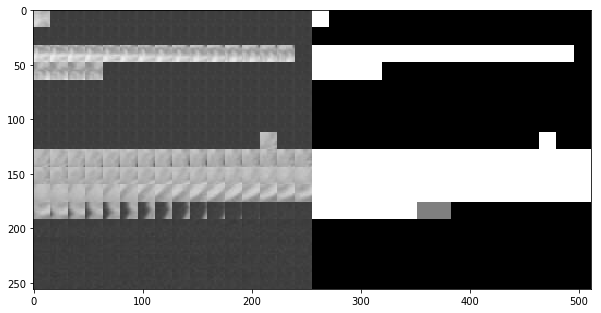

In [4]:
from dataset_tools import *


def data_generator(gmm_loader,
                   epoch_size = cfg.TRAIN.EPOCH_SIZE,
                   shuffle=False):
    for i,(ties,mask) in enumerate(gmm_loader.iterate(shuffle)): 
        if(i >= epoch_size):
            break
        ties = np.transpose(ties,(0,3,1,2)).astype(np.float32)
        mask = mask.astype(np.float32)/255.
        mask[mask <= 0.1] = 0
        mask[mask >= 0.9] = 1.
        mask[(mask < 0.9)&(mask > 0.1)] = 0.5
        yield ties,mask
        
for x,y in data_generator(train_loader,epoch_size=1,shuffle=True):
    x = np.transpose(x,(0,2,3,1)).astype(np.uint8)
    y = (y*255.).astype(np.uint8)
    _y = np.zeros(x.shape[:3],dtype=np.uint8)
    _y[:] = y[:,0,0][:,None,None]
    draw(x,_y)

In [5]:
import theano
import theano.tensor as T

/usr/local/lib/python2.7/dist-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GT 740M (0000:01:00.0)


# Build model

In [6]:
from utils import get_network_str,save_weights,load_weights
import lasagne
from lasagne import layers as L
from lasagne.nonlinearities import rectify
from theano_utils import histogram_loss
from lasagne.regularization import regularize_network_params,l2
from gmm_op import get_gmm,calc_log_prob_gmm,calc_log_prob_gmm_componetwise
from theano_utils import split

data = T.tensor4(name='data')
label = T.tensor3(name='label')

def make_conv(data,num_filters,name,nonl = rectify):
    return L.Conv2DLayer(data,filter_size=(3,3),num_filters=num_filters,
                        nonlinearity=nonl,pad='same',
                        name='conv'+str(name))
    
def make_deconv(data,num_filters,name):
    return  L.Deconv2DLayer(data,12,2,2,crop='valid',name='deconv'+str(name),nonlinearity=rectify)

def FCN(data,ndim=cfg.ndim,verbose=True,model_name=''):
    res = L.InputLayer((None,3,None,None)
                           ,data
                           ,name='data')
    res = L.InputLayer((None,3,None,None)
                           ,data
                           ,name='data')
    res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=6,
                        nonlinearity=rectify,pad='same',
                        name='conv1')
    res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=12,
                        nonlinearity=rectify,pad='same',
                        name='conv2')
    res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=ndim,
                        nonlinearity=None,pad='same',
                        name='conv3')
    if(model_name != ''):
        load_weights(res,model_name)
    print get_network_str(res,incomings=True,outgoings=True)
    sym = lasagne.layers.get_output(res)
    sym = T.transpose(sym,(0,2,3,1))
    sym = sym/(T.sqrt(T.square(sym).sum(-1)+1e-8)[:,:,:,None])
    params = lasagne.layers.get_all_params(res, trainable=True)
    l2_loss = 1e-4 * regularize_network_params(res, l2)
    return res,sym,params,l2_loss
               

def soft_predict_sym(features,means,covars,weights):
    return 1.-T.nnet.sigmoid(calc_log_prob_gmm(features,means,covars,weights))

# Train

In [ ]:
def get_output(X,t_size=cfg.TILE_SIZE,o_size=cfg.OUT_SIZE):
    return X[:,:,(t_size[1]-o_size[1])//2:(t_size[1]+o_size[1])//2,\
              (t_size[0]-o_size[0])//2:(t_size[0]+o_size[0])//2]


def make_train_fn(model_name=''):
    def split_tr_p_n(x,y):
        x_tr_p,x_n = split(x,y)
        x_p = x_tr_p[100:]
        x_tr = x_tr_p[:100]
        return x_tr,x_p,x_n
    
    data = T.tensor4(name='data')
    label = T.tensor3(name='label')
    net,X,params,l2_loss = FCN(data,ndim=cfg.ndim,model_name=model_name)
    X = X[:,X.shape[1]//2:X.shape[1]//2+1,X.shape[2]//2:X.shape[2]//2+1,:]
    X = X.reshape((-1,X.shape[-1]))
    x_tr,x_p,x_n = split_tr_p_n(X,label.flatten())
    m,c,w = get_gmm(x_tr,cfg.gm_num,cfg.ndim)
    p_n = calc_log_prob_gmm(x_n,m,c,w)
    p_p = calc_log_prob_gmm(x_p,m,c,w)
    loss = histogram_loss(p_n,p_p,1e-4,100)[0]+l2_loss
    prediction = T.nnet.sigmoid(T.concatenate([p_p,p_n],axis=0))
    Y = T.concatenate([T.ones_like(p_p),T.zeros_like(p_n)],axis=0)
    G_lr = theano.shared(np.array(0.001, dtype=theano.config.floatX))
    updates = lasagne.updates.adam(loss,params,G_lr)
    train_fn = theano.function([data, label], [loss,X,Y,prediction,m,c,w],\
                               allow_input_downcast=True, updates=updates)
    test_fn =  theano.function([data, label], [loss,X,Y,prediction,m,c,w],\
                               allow_input_downcast=True)
    print 'train_fn compiled'
    return train_fn,test_fn,G_lr,net

train_fn,test_fn,G_lr,net=make_train_fn()

In [ ]:
G_lr.set_value(np.float32(.1))

In [9]:
from sklearn.metrics import average_precision_score

models_acc = []
for j in range(0,15):
    train_loss=0
    train_acc=0
    for i,batch in enumerate(data_generator(train_loader,epoch_size=100,shuffle=True)):        
        res = train_fn(*batch)
        mask = (res[2]>0.9) | (res[2]<0.1)
        acc = average_precision_score(res[2][mask],res[3][mask])
        train_acc +=acc
        train_loss+=res[0]
#         if(res[1] < .8):
#             if( len(hard) < 1000):
#                 hard.append(batch)
#             else:
#                 hard[cur] = batch
#                 cur = (cur+1) % len(hard)
#         for k in range(min(3,len(hard))):
#             batch = hard[np.random.randint(0,len(hard))]
#             res = train_fn(*batch)
        print '\r epoch %i batch %i loss=%.2f ,acc=%.2f l=%.2f a=%.2f'%(j,i,train_loss/float(i+1),train_acc/float(i+1),res[0],acc),
    print ''
    
    train_loss=0
    train_acc=0
    for i,batch in enumerate(data_generator(test_loader,shuffle=False)):
        res = test_fn(*batch)
        mask = (res[2]>0.9) | (res[2]<0.1)
        acc = average_precision_score(res[2][mask],res[3][mask])
        train_acc +=acc
        train_loss+=res[0]
        print '\r test batch %i loss=%.2f ,acc=%.2f l=%.2f a=%.2f,'%(i,train_loss/float(i+1),train_acc/float(i+1),res[0],acc),
    models_acc.append(train_acc)
    print ''
    
    save_weights(net,'models/%s%03d'%(cfg.NAME,j))
    if(j == 50):
        G_lr.set_value(np.float32(0.01))
    print ''

 epoch 0 batch 89 loss=1381.37 ,acc=0.97 l=154.38 a=1.004                                                                      

KeyboardInterrupt: 

# Evaluate model

In [7]:
data=T.tensor4()
feature_sym = FCN(data,model_name='models/'+cfg.NAME)[1]
feature_fn = theano.function([data],feature_sym,allow_input_downcast=True)


In -->     Layer    --> Out    Description                
-------    -----    -------    -----------                
[]         0        [1]        data(None, 3, None, None)  
[0]        1        [2]        conv1(None, 6, None, None) 
[1]        2        [3]        conv2(None, 12, None, None)
[2]        3        []         conv3(None, 12, None, None)


In [8]:
from dataset_tools import *
from gmm_bg_substructor import BackgroundSubtraction
import cv2
import numpy as np

class BgSubstructor:
    def __init__(self,params):
        self.bg_sub = BackgroundSubtraction()
        self.init = False
        self.params = params
        self.i = 0 

    def update(self,features,img):
        img = img.astype(np.float32)
        features = features.astype(np.float32)
        high_threshold_mask = np.zeros(shape=img.shape[0:2], dtype=np.uint8)
        low_threshold_mask = np.zeros_like(high_threshold_mask)
        self.params['channels'] = img.shape[-1]
        if(not  self.init):
            self.bg_sub.init_model(features,img, self.params)
            self.init = True
        self.bg_sub.subtract(self.i,features, img, low_threshold_mask, high_threshold_mask)
        self.i = self.i+1
        return low_threshold_mask
    
    def reset(self,features,img,params):
        self.bg_sub.reset(features,img,params)
        

params = { 
    'algorithm': 'FTSG', 
    'th': 30, 
    'nDs': 5,
    'nDt': 5,
    'nAs': 5,
    'nAt': 5,
    'bgAlpha': 0.02,
    'fgAlpha': 0.5,
    'tb': 4,
    'tf': 20,
    'tl': 0.1,
    'init_variance' : 0.1
}

# params = { 'algorithm': 'grimson_gmm', 
#                         'low': 1.,#*24*24,
#                         'high': 3,#.*24*24,
#                         'alpha': 0.01,
#                         'max_modes': 5,
#                         'channels': 12,
#                         'variance': .01,
#                         'bg_threshold': 0.075,
#                         'min_variance': .005,
#                         'variance_factor': 1.}

def make_ftsg_features(feature_fn,x):
    return feature_fn(np.transpose(x[np.newaxis],(0,3,1,2)))[0]




In [9]:

def make_ftsg_test(feature_fn,params=params,out_dir='results/'+cfg.NAME+'_ftsg',dataset='test_dataset',max_l = 2000,im_size=None,verbose=False):
    iii = 0
    try:
        for d_in,d_out in iterate_folders(dataset,out_dir):
            iii+=1
            if(iii <= 5):
                continue
            bgs = BgSubstructor(params)
            for i,(im,mask) in enumerate(iterate_video(d_in)):
                print '%s %d                   \r'%(d_in,i),
                if not (im_size is None):
                    im,mask = resize(im,mask,im_size)
                features = make_ftsg_features(feature_fn,im.astype(np.float32))
                pred = bgs.update(features.astype(np.float32),im.astype(np.float32))
                cv2.imwrite(d_out+'/%d.png'%(i),pred)
                cv2.imwrite(d_out+'/%d_true.png'%(i),mask)
                cv2.imwrite(d_out+'/%d_input.png'%(i),im)
                if(verbose):
                    cv2.imshow('pred',pred)
                    cv2.imshow('true',mask)
                    cv2.imshow('input',im)
                    cv2.waitKey(1)
                if(i >= max_l):
                    break
            print '%s %d\r'%(d_in,i),
            bgs.reset(features,im.astype(np.float32),params)
            break
    finally:
        if(verbose):
            cv2.destroyAllWindows()
    print 'done'
            
        
make_ftsg_test(feature_fn,
               out_dir='results/'+cfg.NAME+'_fstg1',
               dataset='../gmm_segmentation/test_dataset',
               im_size=(320,240),
               verbose=True)

# make_ftsg_test(lambda x : np.transpose(x,(0,2,3,1)),
#                params,
#                out_dir='results/baseline_ftsg',
#                dataset='../gmm_segmentation/test_dataset',
#                im_size=(320,240),
#                verbose=True)

donemm_segmentation/test_dataset/lowFramerate/port_0_17fps 2000                   
delete bgs


In [8]:
data,m,c,w=T.matrix(),T.matrix(),T.matrix(),T.vector()
predict_fn = theano.function([data,m,c,w],soft_predict_sym(data,m,c,w),allow_input_downcast=True)

# Find parameters for grimpson gmm

In [32]:
from test_tools import make_features,make_gmms,fit_gmms,predict_pixelwise
from dataset_tools import *

    
def fit_gmms(features,gmms,masks = None):
    for i in range(features.shape[1]):
        for j in range(features.shape[2]):
            f = features[:,i,j]
            gmm = gmms[i*features.shape[2]+j]
            if not (masks is None):
                if(len(f[masks[:,i,j] < 30]) > gmm.n_components*3):
                    f = f[masks[:,i,j] < 30]
            gmm.fit(f)

def find_grimson_params(feature_fn,
              dataset='../gmm_segmentation/test_dataset',
              max_frames=300,
              im_size = (320//2,240//2)):
    all_covars = []
    all_weights = []
    all_comp = []
    all_masks = []
    for k,in_dir in enumerate(iterate_folders(dataset)):
        if(k > 4):
            break
        for i,(imgs,masks) in enumerate(iterate_bathced(in_dir,max_frames,im_size)):
            if(masks[(masks>30) & (masks < 240)].size > 0.1*masks.size):
                continue
            print in_dir,'generate_features,',
            data = make_features(feature_fn,imgs)
            gmms = make_gmms(imgs.shape[1:-1],cfg.gm_num)
            print 'fit gmms,',
            fit_gmms(data,gmms,None)
            print 'save'
            cov = np.empty((len(gmms),)+gmms[0].covariances_.shape,dtype=np.float32)
            weights = np.empty((len(gmms),len(gmms[0].weights_)),dtype=np.float32)
            dists = np.empty((len(gmms),len(imgs),len(gmms[0].weights_)),dtype=np.float32)
            data = data.reshape((len(imgs),-1,gmms[i].means_.shape[1]))
            for j in range(len(gmms)):
                cov[j] = gmms[j].covariances_
                weights[j] = gmms[j].weights_
                dists[j] = ((data[:,j,None,:]-gmms[j].means_[None,:,:])**2).sum(-1)
            print 'cov',cov.mean(),cov.std()
            masks = masks.reshape((len(masks),-1))
            masks = np.transpose(masks,(1,0))
            print 'cov bg',dists[masks < 0.5].min(-1).mean(),dists[masks < 0.5].min(-1).std()
            print 'cov motion',dists[masks > 0.5].min(-1).mean(),dists[masks > 0.5].min(-1).std()
                
    print 'test complete'
    
    
find_grimson_params(feature_fn,max_frames=70,im_size=(50,30))

../gmm_segmentation/test_dataset/badWeather/blizzard generate_features, fit gmms, save
cov 3.94147e-05 0.000103344
cov bg 0.000408757 0.00131152
cov motion 0.00412241 0.00594052
../gmm_segmentation/test_dataset/badWeather/blizzard generate_features, fit gmms, save
cov 6.26969e-05 0.000219755
cov bg 0.0005802 0.00225499
cov motion 0.00689157 0.0111651
../gmm_segmentation/test_dataset/badWeather/blizzard generate_features, fit gmms, save
cov 8.86901e-05 0.000343437
cov bg 0.000745391 0.00301777
cov motion 0.00935635 0.0149117
../gmm_segmentation/test_dataset/badWeather/blizzard generate_features, fit gmms, save
cov 0.000109387 0.000359772
cov bg 0.000934695 0.00331321
cov motion 0.0110193 0.0157363
../gmm_segmentation/test_dataset/badWeather/blizzard generate_features, fit gmms, save
cov 0.000489362 0.00138863
cov bg 0.001962 0.00674359
cov motion 0.0331518 0.0350964
../gmm_segmentation/test_dataset/badWeather/blizzard generate_features, fit gmms, save
cov 0.000136353 0.000449471
cov bg 

KeyboardInterrupt: 

In [27]:
print cov.mean(),cov.std()
print dists.mean(),dists.std()

0.00160343 0.00311698
0.0737661 0.137147


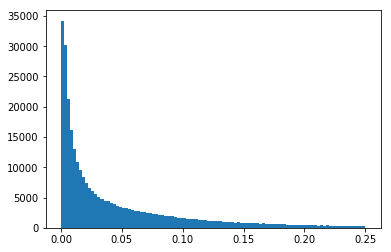

In [30]:
_ = plt.hist(dists[dists< 0.25].flatten(),100)

In [25]:
print cov.mean(),cov.std()
print dists.mean(),dists.std()

0.00333289 0.00530234
0.137302 0.193557


In [23]:
print cov.mean(),cov.std()
print dists.mean(),dists.std()

0.00052132 0.00244013
0.0299029 0.131406


In [21]:
print cov.mean(),cov.std()
print dists.mean(),dists.std()

2.24339e-05 1.57023e-05
0.000521671 0.000497438


In [ ]:
def classify(cov,weights,dists,masks):
    comp = dists.argmin(-1)
    masks = np.transpose(masks.reshape((len(masks),-1)),(0,1))
    
    

In [ ]:
from test_tools import make_features,make_gmms,fit_gmms,predict_pixelwise
from dataset_tools import *
def make_test(feature_fn,predict_fn,
              out_dir='results/'+cfg.NAME,
              dataset='dataset',
              max_frames=300,
              im_size = (320//2,240//2)):
    for in_dir,out_dir in iterate_folders(dataset,out_dir):
        for i,(imgs,masks) in enumerate(iterate_bathced(in_dir,max_frames,im_size)):
            if(masks[(masks>30) & (masks < 240)].size > 0.1*masks.size):
                continue
            print in_dir,'generate_features,',
            data = make_features(feature_fn,imgs)
            gmms = make_gmms(imgs.shape[1:-1],cfg.gm_num)
            print 'fit gmms,',
            fit_gmms(data[:100],gmms,masks[:100])
            print 'predict,',
            prediction = predict_pixelwise(data[100:],gmms,predict_fn)
            print 'save'
            imgs = imgs[100:]
            masks = masks[100:]      
            prediction = (prediction*255).astype(np.uint8)
            for i in range(len(imgs)):
                cv2.imwrite(out_dir+'/'+str(i)+'.png',prediction[i])
                cv2.imwrite(out_dir+'/'+str(i)+'_true.png',masks[i])
                cv2.imwrite(out_dir+'/'+str(i)+'_input.jpg',imgs[i])
            break
            print ''
    print 'test complete'

In [24]:
make_test(feature_fn,predict_fn,dataset='../gmm_segmentation/test_dataset')

../gmm_segmentation/test_dataset/badWeather/blizzard generate_features, fit gmms,


# Calc metric

In [7]:
from sklearn.metrics import average_precision_score
import os


def calc_metrics_imgs(predict,label):
    predict,label = predict.flatten(),label.flatten()
    mask = (label>230)|(label < 50)
    p = (predict.astype(np.float32)/255.)[mask]
    y = (label.astype(np.float32)/255.)[mask]
    y[y>0.5] = 1.
    y[y<=0.5] = 0.
    bp = np.zeros_like(p)
    bp[p>0.5] = 1.
    TP = (bp*y).sum()
    TN = ((1-bp)*(1-y)).sum()
    FP = (bp*(1.0-y)).sum()
    FN = ((1.0-bp)*y).sum()
    AveragePrecision = 0#average_precision_score(y,p)
    return np.array([TP,TN,FP,FN],dtype=np.int64),AveragePrecision
    

def print_results(results):
    s = ''
    for k in results.keys():
        s=s+k+str(': ')+str(results[k])+'\n'
    return s

def calc_metrics_folder(data_dir):
    S = np.array([0,0,0,0],dtype=np.int64)
    AveragePrecision = 0.0
    nums = [int(i[:-4]) for i in os.listdir(data_dir) if i.find('true') < 0 and  i.find('input') < 0]
    for i in nums:
        m = cv2.imread(data_dir+'/%i_true.png'%(i))
        p = cv2.imread(data_dir+'/%i.png'%(i))
        cv2.imshow('p',p)
        cv2.waitKey(1)
        _s = calc_metrics_imgs(p,m)
        AveragePrecision += _s[1]
        S+=_s[0]
        
    TP,TN,FP,FN = S[0],S[1],S[2],S[3]
    results = dict( AveragePrecision = AveragePrecision/float(len(nums)),\
                    Recall = TP / float(TP + FN),\
                    Sp = TN / float(TN + FP),\
                    FPR = FP / float(FP + TN),\
                    FNR = FN / float(TP + FN),\
                    PWC =  100 * (FN + FP) / float(TP + FN + FP + TN),\
                    F_Measure  =  (2 * (TP / float(TP + FP)) * (TP / float(TP + FN))) / (TP / float(TP + FP) +  TP / float(TP + FN)),\
                    Precision  = TP / float(TP + FP))
    
    print data_dir
    print print_results(results)
    return results

def calc_metric_all_folders(data_dir):
    res = []
    f = open(data_dir+'.txt','w')
    for j in os.listdir(data_dir):
        folder = data_dir+'/'+j+'/'+os.listdir(data_dir+'/'+j)[0]
        results = calc_metrics_folder(folder)
        if not (results is None):
            res.append(results)
            f.write(folder+'\n')
            f.write(print_results(results))
    results = dict()
    for k in res[0].keys():
        results[k] = np.array([i[k] for i in res]).mean()
    f.write('total result\n')
    f.write(print_results(results))
    f.close()
    print 'total result'
    print print_results(results)

calc_metric_all_folders('results/'+cfg.NAME+'_fstg1')

results/conv_net_no_bn_ndim12010_fstg1/badWeather/blizzard
AveragePrecision: 0.0
FNR: 0.602590291612
Recall: 0.397409708388
Sp: 0.997584780055
Precision: 0.738885924438
PWC: 1.25622277161
FPR: 0.00241521994546
F_Measure: 0.516838103184

results/conv_net_no_bn_ndim12010_fstg1/baseline/highway
AveragePrecision: 0.0
FNR: 0.183344085157
Recall: 0.816655914843
Sp: 0.983175415592
Precision: 0.754306127222
PWC: 2.67303573706
FPR: 0.0168245844078
F_Measure: 0.78424372315

results/conv_net_no_bn_ndim12010_fstg1/cameraJitter/badminton
AveragePrecision: 0.0
FNR: 0.781165776855
Recall: 0.218834223145
Sp: 0.996234759658
Precision: 0.665190710855
PWC: 2.94616858092
FPR: 0.00376524034222
F_Measure: 0.329326666827

results/conv_net_no_bn_ndim12010_fstg1/dynamicBackground/boats
AveragePrecision: 0.0
FNR: 0.913602880455
Recall: 0.0863971195455
Sp: 0.947419353856
Precision: 0.0481064577241
PWC: 7.82727575596
FPR: 0.0525806461445
F_Measure: 0.0618014697195

results/conv_net_no_bn_ndim12010_fstg1/intermitt

In [5]:
import pandas as pd
def parse_results(dir_results):
    for i  in os.listdir(dir_results):
        